# File chứa 2 mô hình dùng cho việc chạy thực nghiệm trên tập NF corpus

# Load library

In [ ]:
import nltk
nltk.download(['punkt' , 'stopwords', 'wordnet'])

In [ ]:
from nltk.tokenize import word_tokenize , sent_tokenize
from nltk.sentiment import SentimentAnalyzer
import pandas as pd
import math
import numpy as np
import os
from wordcloud import WordCloud, STOPWORDS
from string import punctuation
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer , SnowballStemmer
from scipy.linalg import svd
from tqdm import tqdm
from operator import itemgetter

# Tải dữ liệu


In [ ]:
nf_path = os.path.join("D:/Python project/SearchNews", "nfcorpus") 
names=["dev.docs","test.docs","train.docs"]
data_nf = []
with open(os.path.join(nf_path , names[1]), 'r') as file:
    for line in file:
            data_nf.append(line.rstrip())

In [ ]:
data_nf

In [ ]:
iddoc=[]
for i in data_nf:
    iddoc.append(i.split()[0])

In [ ]:
data_train_nf = data_nf

## Tiền xử lý dữ liệu NF Corpus
1.   Lọc và chỉ lấy các từ 
2.   Tách từ trong câu
3.   Loại bỏ stopwords 
4.   Sử dụng phương pháp stemma để đưa từ hiện tại về từ gốc của nó

In [ ]:
#1 lọc và chỉ lấy các từ
data_nf_train_word = []
for sample in data_train_nf:
    temp = []
    for character in sample.split():
        if character.isalpha():
           temp.append(character)
    data_nf_train_word.append(' '.join(temp))

In [ ]:
#2 tách từ trong câu
data_nf_train_token = [word_tokenize(sample) for sample in data_nf_train_word]

In [ ]:
data_nf_train_token[0]

In [ ]:
#lọc stopwords
list_english_stopwords = stopwords.words('english')
data_nf_train_stopwords_token = []
for sample in data_nf_train_token:
    temp  = []
    for word in sample:
        if word not in list_english_stopwords:
           temp.append(word) 
    data_nf_train_stopwords_token.append(temp)    

In [ ]:
# stemmer = EnglishStemmer()
# stemmer = PorterStemmer()
stemmer =LancasterStemmer()
# stemmer = WordNetLemmatizer()
processed_data_nf_train_token =[]
for sample in data_nf_train_stopwords_token:
    temp = []
    for word in sample:
        temp.append(stemmer.stem(word))
        # temp.append(stemmer.lemmatize(word))
    processed_data_nf_train_token.append(temp)

In [ ]:
preprocessed_data_token = processed_data_nf_train_token

In [ ]:
preprocessed_data_token[0]

In [ ]:
iddoc

# Train Vector Space Model


In [ ]:
IId={} #từ điển lưu các id document của từng từ , dạng bảng băm
for i in range(len(preprocessed_data_token)):
  check = preprocessed_data_token[i]
  for item in preprocessed_data_token[i]:
    if item in check:
      if item not in IId:
          IId[item]=[]
      if item in IId:
          IId[item].append(iddoc[i])

In [ ]:
IId

Tạo bảng từ vựng

In [ ]:
vocab=pd.DataFrame(columns=['Key','Frequency']) #tạo bảng từ vựng sau khi tiền xử lý
index=[] # lưu các từ vựng duy nhất
doc_num=[] #tạo list chứa số lượng tài liệu mà k xuất hiện
idf=[] # tạo list lưu idf của từng từ
for item in IId:
  index.append(item)
for i in range(len(index)):
  vocab.loc[i]=[index[i],len(IId[index[i]])] #tính frequency
for i in range(len(IId)):
  docNum=len(set(IId[index[i]]))
  doc_num.append(docNum)
  idf.append(math.log(len(preprocessed_data_token)/docNum))  
vocab.insert(1,"Doc Num", doc_num,True)
vocab.insert(3,"IDF",idf,True)
vocab.set_index("Key", inplace=True)

In [ ]:
vocab

Posting List

In [ ]:
PL={} #Khởi tạo Posting List
count=1
for i in range(len(IId)):
  name=index[i]
  PL[name] = []
  PL[name].append([IId[name][0],1])
  for j in range(1,len(IId[name])):
    if IId[name][j]!=IId[name][j-1]:
      PL[name].append([IId[name][j],1])
    else:
      count=PL[name][-1][-1]
      PL[name][-1].append(count+1)
      PL[name][-1].pop(-2)

In [ ]:
PL

TF tính theo cách: tf_{ik} = In(tk_{ik}) + 1

In [ ]:
for i in range(len(PL)):
  for j in range(len(PL[index[i]])):
    id=PL[index[i]][j][0]
    term_num_in_doc=PL[index[i]][j][1]
    total_term=len(preprocessed_data_token[iddoc.index(id)])
    PL[index[i]][j].append(term_num_in_doc/total_term)

TFIDF tính theo: $ w_{ik}=tf_{ik}*idf_k$

In [ ]:
w=[]
for name in index:
  for i in range(len(PL[name])):
    w.append([PL[name][i][0],PL[name][i][2]*vocab.loc[name]["IDF"]]) #lấy cột IDF của danh sách vocab nhân với cột TF của posting list

Normalize bằng cách chia mỗi weight cho tổng toàn bộ weight trong tài liệu i

Trong Posting list, cột thứ 3 là TF, thứ 4 là weight đã normalized

In [ ]:
import itertools
new_list = [(a, list(b)) for a, b in itertools.groupby(sorted(w, key=lambda x:x[0]), key=lambda x:x[0])]#gom nhóm theo id của tài liệu
final_data = [[a, math.sqrt(sum(math.pow(c[1],2) for c in d))] for a, d in new_list] #tính norm dựa trên chuẩn cosin (test: 0.38)
# final_data = [[a, sum(c[1] for c in d)] for a, d in new_list]  # tính norm dựa trên chuẩn tổng (test:0.3648)
# final_data = [[a, sum(math.pow(c[1],4) for c in d)] for a, d in new_list] #tính norm dựa trên chuẩn bậc 4  (test: 0.1416)

In [ ]:
new_final_data = {}
for item in final_data:
    new_final_data[item[0]] = item[1]

In [ ]:
for i in w:
    i[1] = i[1] /new_final_data[i[0]]

In [ ]:
index_of_w=0
for i in range(len(PL)):
  for j in range(len(PL[index[i]])):
    PL[index[i]][j].append(w[index_of_w][1])  # bổ sung cột trọng số của từng term vào danh sách posting list.
    index_of_w = index_of_w + 1

In [ ]:
PL

## Query

In [ ]:
def unique(list1):
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    return unique_list

In [ ]:
def query_to_terms(query):#hàm query_to_terms có nhiệm vụ tiền xử lý các câu truy vấn trước khi đưa vào mô hình vector cho việc tìm kiếm
  a = []
  #lọc và chỉ lấy các phần tử là từ
  for sample in query:
      temp = []
      for character in sample.split():
          if character.isalpha():#kiểm tra phần tử có phải là từ hay không ?
            temp.append(character)
      a.append(temp)
  b=[]
  #kiểm tra từ có thuộc stopwords hay không, nếu không phải stopwords thì sử dụng stemmer để đưa từ đó về từ gốc
  for sample in a:
    temp  = []
    for word in sample:
        if word not in list_english_stopwords: #kiểm tra từ đó stopwords hay không ?
          temp.append(stemmer.lemmatize(word)) #sử dụng stemmer để đưa từ về từ gốc
          # temp.append(stemmer.lemmatize(word))
    b.append(temp)
  return b

## Xử lý câu query từ file truy vấn

In [ ]:
nf_path = os.path.join("D:/Python project/SearchNews", "nfcorpus") 
query = []
names=["dev.all.queries","test.all.queries" ,"train.all.queries"]
with open(os.path.join(nf_path , names[2]), 'r',encoding="utf8") as file:
    for line in file:
        query.append(line.rstrip())

In [ ]:
len(query)

## Query Processing

In [ ]:
index

In [ ]:
queries=query_to_terms(query) #xử lý các từ trong mỗi câu truy vấn bằng hàm query_to_terms

In [ ]:

for i in range(len(queries)):
 check = queries[i]
 queries[i]=unique(queries[i]) #sử dụng hàm unique để lọc ra term duy nhất trong mỗi truy vấn, từ đó ta có queries mới 
 for j in range(len(queries[i])):#duyệt qua từng queries
    if(queries[i][j] in index):
            term=queries[i][j] #xác định term
            queries[i][j]=[term] #cập nhật lại 1 mảng lưu term và trọng số của nó Ví dụ: ['smile', 0.746478564]
            queries[i][j].append((check.count(term)/len(check))*(vocab.loc[term]["IDF"]))
    else:
            term=queries[i][j] #xác định term
            queries[i][j]=[term] 
            queries[i][j].append("NaN") 
          

In [ ]:
queries

Normalizing Weights of Term in Query List

In [ ]:
while True:
    for q in queries:
        for term in q:
            if term[1] == 'NaN':
               q.remove(term)
    count_NaN = 0
    for q in queries:
        for term in q:
            if term[1] == 'NaN':
                 count_NaN +=1
    if count_NaN == 0:
           break

In [ ]:
queries

In [ ]:
"""
Chuẩn hoá các trọng số của từng term trong mỗi truy vấn sử dụng công thức w_new = w /(w1 + w2 +...+wn) với n là số lượng term của câu truy vấn tương ứng.
"""
for q in queries:
  sum_w=0
  for term in q:
    sum_w += math.pow(term[1] , 2)
  sum_w = math.sqrt(sum_w)
  for term in q:
    term[1]=term[1]/sum_w

In [ ]:
query_id=[]
for q in query:
    query_id.append(q.split()[0])

In [ ]:
query_id

# Train Latent Semantic Index Model

In [ ]:
import gc
gc.collect()
gc.freeze()

In [ ]:
senti = SentimentAnalyzer()

In [ ]:
all_words_data = senti.all_words(preprocessed_data_token)

In [ ]:
dict_word_frequency_all_docs = nltk.FreqDist(all_words_data)
list_unique_words = list(dict_word_frequency_all_docs.keys())

In [ ]:
array_freq_word = []
for word in list_unique_words:
    temp = []
    for i in range(len(preprocessed_data_token)):
        temp.append(preprocessed_data_token[i].count(word))
    array_freq_word.append(temp)

In [ ]:
array_freq_word = np.array(array_freq_word)

## Tính term vector và document vector

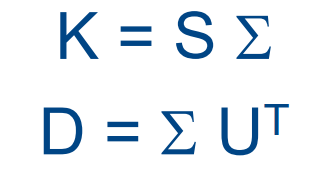

In [ ]:
def SVD_with_k_dimensional(U , Sigma  , VT , K):
     new_Sigma = np.zeros((K , K))
     new_Sigma[:K ,:K] = np.diag(Sigma[:K])
     new_VT = VT[:K]
     new_U = U[:,range(K)]
     term_vector = np.dot(new_U , new_Sigma)
     document_vector = np.dot(new_Sigma , new_VT)
     return term_vector  , document_vector

In [ ]:
U , Sigma , VT = svd(array_freq_word) # sử dụng SVD để tách ma trận doc-term

## Tạo từ điển term_vector và document_term

In [ ]:
def create_dict_term_and_document(term_vector , document_vector):
    dict_term_vector = {}
    for i in range(len(list_unique_words)):
        dict_term_vector[list_unique_words[i]] = term_vector[i]
    dict_document_vector ={}
    for i in range(len(preprocessed_data_token)):
        dict_document_vector[iddoc[i]] = document_vector[:,i]
    return dict_term_vector , dict_document_vector

## Query

In [ ]:
nf_path = os.path.join("D:/Python project/SearchNews", "nfcorpus")
query = []
names=["test.all.queries"]
for name in names:
    with open(os.path.join(nf_path , name), 'r',encoding="utf8") as file:
        for line in file:
             query.append(line.rstrip())

In [ ]:
len(query)

In [ ]:
query_id=[]
for q in query:
    query_id.append(q.split()[0])

## Tiền xử lý câu truy vấn

In [ ]:
def preprocess_text(sent):
    temp_sent = []
    for word in sent.split(): #lọc và chỉ lấy từ
        if word.isalpha():
            temp_sent.append(word)
    temp_sent = " ".join(temp_sent)
    #tokenize
    temp_sent = word_tokenize(temp_sent)
    #stopwords
    new_temp_sent  = []
    for i in range(len(temp_sent)):
        if temp_sent[i] not in list_english_stopwords:
               new_temp_sent.append(temp_sent[i])
    #stemmer
    for i in range(len(new_temp_sent)):
        new_temp_sent[i] = stemmer.stem(new_temp_sent[i])
    return " ".join(new_temp_sent)  

In [ ]:
for i in range(len(query)):
    query[i] =  preprocess_text(query[i])

In [ ]:
query[0]

## Query Processing

In [ ]:
def query_processing(dict_term_vector , i):
    sum_vector_query =[]
    for sent in query:
        temp = []
        for word in sent.split():
            try:
                temp.append(dict_term_vector[word])
            except:
                pass
        sum_vector_query.append(np.sum(temp , axis=0, dtype=float)/len(temp))
    return sum_vector_query  

# Đánh giá 2 mô hình với NF Corpus

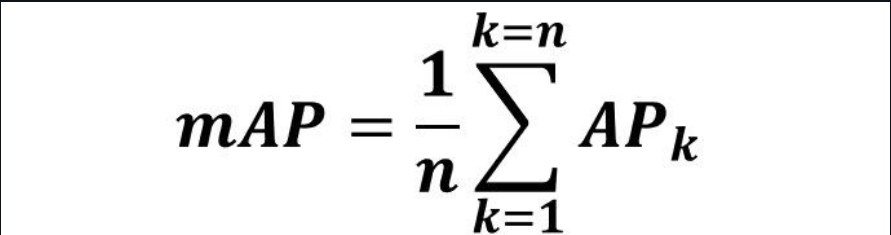

## Tải bộ kết quả tài liệu liên quan thực tế

In [ ]:

from scipy.spatial.distance import cosine , euclidean

In [ ]:
nf_path = os.path.join("D:/Python project/SearchNews", "nfcorpus") 
res = []
names=["dev.3-2-1.qrel", "test.3-2-1.qrel", "train.3-2-1.qrel"]
with open(os.path.join(nf_path , names[1]), 'r',encoding="utf8") as file:
    for line in file:
        res.append(line.rstrip())

In [ ]:
response={}
for i in res:
    a =i.split()[0]
    if a not in response:
        response[a]=[]
    if a in response:
        response[a].append(i.split()[2])


In [ ]:
response

## Vector Space Model - dự đoán tài liệu liên quan

In [ ]:
def find_and_add(arr,doc_id,value):
  for i in range(len(arr)):
    if arr[i][0]== doc_id:
         arr[i][1]+=value
  return arr

In [ ]:
#tạo danh sách (id_docs ,weight) cho từng truy vấn
from operator import itemgetter
predict_result = [] #danh sách lưu kết quả dự đoán tài liệu liên quan của từng truy vấn
for i in tqdm(range(len(queries))):
  q=queries[i]
  results=[]
  for key in q:
    for j in PL[key[0]]:
      results.append([j[0],j[3]*key[1]])
  doc_rank=[]#lưu trữ (id duy nhất , weight) của từng truy vấn
  check=[]
  for result in results:
    doc_id = result[0]
    if doc_id not in check:
      check.append(doc_id)
      doc_rank.append(result)
    else:
      doc_rank=find_and_add(doc_rank,doc_id,result[1])
  arr=sorted(doc_rank, key=itemgetter(1))#sắp xếp doc_rank theo thứ tự từ bé đến lớn
  predict_result.append(arr[-(len(response[query_id[i]])):])#lấy số phần tử có  w cao nhất với số lượng bằng với số tài liệu của mỗi truy vấn trong tập RES

In [ ]:
#tạo danh sách kết quả mới chỉ lưu các id tài liệu của mỗi truy vấn
new_predict_result_Vector_Space = []
for sample in predict_result:
    temp = []
    for row in sample:
        temp.append(row[0])
    new_predict_result_Vector_Space.append(temp)

## Latent Semantic Index model - dự đoán tài liệu liên quan

In [ ]:
def predict_result(dict_document_vector , sum_vector_query):
    predict_result = []
    for i in range(len(sum_vector_query)):
        temp = []
        for id , item in dict_document_vector.items():
            temp.append([id , math.dist(sum_vector_query[i] , item)])
        temp.sort(reverse = False , key = itemgetter(1))
        predict_result.append(temp[:len(response[query_id[i]])])
    new_predict_result_LSI = []
    for sample in predict_result:
        temp = []
        for row in sample:
            temp.append(row[0])
        new_predict_result_LSI.append(temp)
    return new_predict_result_LSI

## Sử MAP nội suy cho đánh giá 2 model

In [ ]:
def MAP_model(new_predict_result , real_result): #hàm tính MAP chung cho 2 mô hình
    #tạo danh sách kết quả kiểm tra xem id tài liệu nào có xuất hiện trong tập dự đoán và tập thực tế
    result = []
    for i in range(len(new_predict_result)):
        temp = {}
        for id_docs in new_predict_result[i]:
            if id_docs in response[query_id[i]]:
                temp[id_docs]  = True
            else:
                temp[id_docs] = False
        result.append(temp)
    #tính precision và recall cho từng truy vấn
    precision_recall_queries =[]
    i = 0 
    for sample in result:
        if len(sample) == 0:
            precision_recall_queries.append([])
        else:
            count_appear = 0
            count = 0
            temp = []
            for id_docs , appear in sample.items():
                if appear == False:
                    count +=1
                elif appear == True:
                    count_appear +=1
                    count +=1
                    temp.append([count_appear/count, count_appear/len(response[query_id[i]])])
            precision_recall_queries.append(temp)
        i = i+1  
    #tính AP nội suy cho từng truy vấn
    result_AP_queries  = []
    for sample in precision_recall_queries:
        if len(sample) == 0:
            result_AP_queries.append(0.0)
        else:
            AP = []
            for i in range(len(sample)):
                AP.append(sample[i][0])
            result_AP_queries.append(sum(AP)/len(AP))
    return np.mean(result_AP_queries)

### Vector Space Model

In [ ]:
MAP_model(new_predict_result_Vector_Space , response)   #vector space model

### Latent Semantic Index

In [ ]:
MAP_result = [] #LSI model
for i in tqdm(range(1, 201, 2)):
    term_vector , document_vector = SVD_with_k_dimensional(U , Sigma , VT , i)
    dict_term_vector , dict_document_vector = create_dict_term_and_document(term_vector , document_vector)
    sum_query_vector = query_processing(dict_term_vector , i)
    new_predict_result_LSI = predict_result(dict_document_vector , sum_query_vector)
    MAP_result.append(MAP_model(new_predict_result_LSI, response))

In [ ]:
#Show dữ liệu
import matplotlib.pyplot as plt
plt.plot(range(1 , 201 , 2) , MAP_result)
plt.show()

In [ ]:
max(MAP_result) #tìm kết quả MAP lớn nhất

In [ ]:
print("dim for SVD" , MAP_result.index(max(MAP_result)))